<a href="https://colab.research.google.com/github/gpasxos/large-scale-optimization/blob/main/ch05_ADMM_LASSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Solve the LASSO problem: $\text{minimize}_x \frac{1}2\|Ax-b\|^2+\lambda\|x\|_1$ using ADMM.

Reformulate the problem as:
$$\text{minimize}_{x,z} \frac{1}2\|Ax-b\|^2+\lambda\|z\|_1\\
\text{subject to}~~ x-z=0$$

Then use ADMM to obtain the updates:
$$x^{(k+1)} = (A^TA+\rho I)^{-1}(A^Tb+\rho(z^{(k)}-u^{(k)}))$$
and
$$z^{(k+1)}=\mathcal{S}_{\lambda/\rho}(x^{(k+1)}+u^{(k)})$$
where
$$\mathcal{S}_{\tau}(x)= \text{sign}(x) \odot (|x| - \tau)^+$$


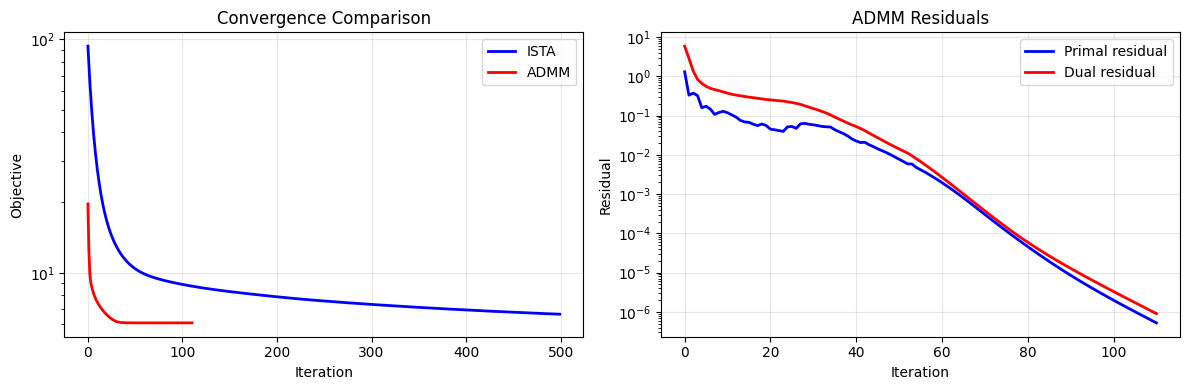

ISTA final objective: 6.639108
ADMM final objective: 6.094676
Recovery error ISTA: 3.7455
Recovery error ADMM: 1.2880


In [2]:
import numpy as np
import matplotlib.pyplot as plt

def prox_l1(x, tau):
    """Soft-thresholding operator."""
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0)

def lasso_ista(A, b, lambda_reg, L=None, max_iter=1000, tol=1e-6):
    """
    Solve LASSO via ISTA (Iterative Soft-Thresholding Algorithm).
    min_x 0.5 * ||Ax - b||^2 + lambda * ||x||_1
    """
    m, n = A.shape

    # Lipschitz constant for A'A
    if L is None:
        L = np.linalg.norm(A.T @ A)
    t = 1.0 / L

    x = np.zeros(n)
    history = {'objective': []}

    for k in range(max_iter):
        grad_f = A.T @ (A @ x - b)
        x_new = prox_l1(x - t * grad_f, lambda_reg * t)

        obj = 0.5 * np.sum((A @ x_new - b)**2) + lambda_reg * np.sum(np.abs(x_new))
        history['objective'].append(obj)

        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new

    return x, history

def lasso_admm(A, b, lambda_reg, rho=1.0, max_iter=1000, tol=1e-6):
    """
    Solve LASSO via ADMM.
    min_x 0.5 * ||Ax - b||^2 + lambda * ||x||_1
    ADMM form: min_{x,z} 0.5*||Ax-b||^2 + lambda*||z||_1 s.t. x = z
    """
    m, n = A.shape

    # Precompute
    AtA = A.T @ A
    Atb = A.T @ b
    L_chol = np.linalg.cholesky(AtA + rho * np.eye(n)) # For fast solves

    # Initialize
    x = np.zeros(n)
    z = np.zeros(n)
    u = np.zeros(n) # Scaled dual variable

    history = {'objective': [], 'primal_residual': [], 'dual_residual': []}

    for k in range(max_iter):
        # x-update: solve (A'A + rho*I)x = A'b + rho*(z - u)
        x_new = np.linalg.solve(L_chol.T, np.linalg.solve(L_chol, Atb + rho * (z - u)))

        # z-update: soft-thresholding
        z_old = z.copy()
        z = prox_l1(x_new + u, lambda_reg / rho)

        # u-update
        u = u + x_new - z

        # Compute residuals
        primal_res = np.linalg.norm(x_new - z)
        dual_res = np.linalg.norm(rho * (z - z_old))

        # Objective
        obj = 0.5 * np.sum((A @ x_new - b)**2) + lambda_reg * np.sum(np.abs(z))

        history['objective'].append(obj)
        history['primal_residual'].append(primal_res)
        history['dual_residual'].append(dual_res)

        x = x_new
        # Check convergence
        if primal_res < tol and dual_res < tol:
            break

    return z, history # Return z as it satisfies the sparsity constraint

def compare_ista_admm():
    """Compare ISTA and ADMM for LASSO."""
    np.random.seed(42)

    n, m = 200, 100
    k = 20 # Sparsity

    # Generate problem
    A = np.random.randn(m, n) / np.sqrt(m)
    x_true = np.zeros(n)
    x_true[np.random.choice(n, k, replace=False)] = np.random.randn(k) * 3
    b = A @ x_true + 0.1 * np.random.randn(m)

    lambda_reg = 0.1

    # Solve with both methods
    x_ista, hist_ista = lasso_ista(A, b, lambda_reg, max_iter=500)
    x_admm, hist_admm = lasso_admm(A, b, lambda_reg, rho=1.0, max_iter=500)

    # Plot comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Objective
    axes[0].semilogy(hist_ista['objective'], 'b-', label='ISTA', linewidth=2)
    axes[0].semilogy(hist_admm['objective'], 'r-', label='ADMM', linewidth=2)
    axes[0].set_xlabel('Iteration')
    axes[0].set_ylabel('Objective')
    axes[0].set_title('Convergence Comparison')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Residuals (ADMM) - ISTA doesn't typically track primal/dual residuals directly in the same way as ADMM
    axes[1].semilogy(hist_admm['primal_residual'], 'b-', label='Primal residual', linewidth=2)
    axes[1].semilogy(hist_admm['dual_residual'], 'r-', label='Dual residual', linewidth=2)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('Residual')
    axes[1].set_title('ADMM Residuals')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('ista_vs_admm.pdf', bbox_inches='tight')
    plt.show()

    print(f"ISTA final objective: {hist_ista['objective'][-1]:.6f}")
    print(f"ADMM final objective: {hist_admm['objective'][-1]:.6f}")
    print(f"Recovery error ISTA: {np.linalg.norm(x_ista - x_true):.4f}")
    print(f"Recovery error ADMM: {np.linalg.norm(x_admm - x_true):.4f}")

compare_ista_admm()